In [1]:
# LDA with n-grams

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import nltk

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['list of words if needed'])

In [4]:
df = pd.read_csv('/Users/vibhuverma/Desktop/CLASSWORK/BUSINESS PRACTICUM/Anti-Corruption/Data Provided/USAID_Project_Data/USAID_Anticorruption_Projects_Database.csv')

In [5]:
df.drop(['proj_res','rfp_rftop','final_res','mind_eval','final_eval','audit','interim_rep','addl_docs','addl_info'],axis=1,inplace=True)

In [6]:
df= df[['proj_desc']]
df


,proj_desc
0,The five components of this program seek to ta...
1,The overall goal of the program was to support...
2,The project focused on strengthening and impro...
3,The Political Party Assessment team aimed to r...
4,The Justice Sector Strengthening Project (JuST...
...,...
310,The Yemen Responsive Governance Project (RGP) ...
311,The Enhancing Government Effectiveness (EGE) i...
312,The Basic Health Services (BHS) project was d...
313,The program was designed to reduce administrat...


In [7]:
# Convert to list
data = df.proj_desc.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['The five components of this program seek to take what already exists and '
 'improve upon it, implement it and find ways to ensure that the progress '
 'achieved is sustainable over the long term. The project will help the '
 'government of the Islamic Republic of Afghanistan strengthen its High Office '
 'of Oversight (HOO) - making it a strong, effective institution that is able '
 'to lead, monitor, coordinate and report on efforts to combat corruption '
 'across the country. The project will work and implement a program of '
 'institutional development and sustainability. It will also support the '
 'office in carrying out its priority responsibilities in asset registration '
 'and verification, complaints management and case tracking, and coordination '
 'and monitoring of anticorruption performance across other government '
 'agencies.']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'five', 'components', 'of', 'this', 'program', 'seek', 'to', 'take', 'what', 'already', 'exists', 'and', 'improve', 'upon', 'it', 'implement', 'it', 'and', 'find', 'ways', 'to', 'ensure', 'that', 'the', 'progress', 'achieved', 'is', 'sustainable', 'over', 'the', 'long', 'term', 'the', 'project', 'will', 'help', 'the', 'government', 'of', 'the', 'islamic', 'republic', 'of', 'afghanistan', 'strengthen', 'its', 'high', 'office', 'of', 'oversight', 'hoo', 'making', 'it', 'strong', 'effective', 'institution', 'that', 'is', 'able', 'to', 'lead', 'monitor', 'coordinate', 'and', 'report', 'on', 'efforts', 'to', 'combat', 'corruption', 'across', 'the', 'country', 'the', 'project', 'will', 'work', 'and', 'implement', 'program', 'of', 'institutional', 'development', 'and', 'sustainability', 'it', 'will', 'also', 'support', 'the', 'office', 'in', 'carrying', 'out', 'its', 'priority', 'in', 'asset', 'registration', 'and', 'verification', 'complaints', 'management', 'and', 'case', 'tracking

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'five', 'components', 'of', 'this', 'program', 'seek', 'to', 'take', 'what', 'already', 'exists', 'and', 'improve', 'upon', 'it', 'implement', 'it', 'and', 'find', 'ways', 'to', 'ensure', 'that', 'the', 'progress', 'achieved', 'is', 'sustainable', 'over', 'the', 'long_term', 'the', 'project', 'will', 'help', 'the', 'government', 'of', 'the', 'islamic_republic', 'of', 'afghanistan', 'strengthen', 'its', 'high', 'office', 'of', 'oversight', 'hoo', 'making', 'it', 'strong', 'effective', 'institution', 'that', 'is', 'able', 'to', 'lead', 'monitor', 'coordinate', 'and', 'report', 'on', 'efforts', 'to', 'combat', 'corruption', 'across', 'the', 'country', 'the', 'project', 'will', 'work', 'and', 'implement', 'program', 'of', 'institutional', 'development', 'and', 'sustainability', 'it', 'will', 'also', 'support', 'the', 'office', 'in', 'carrying', 'out', 'its', 'priority', 'in', 'asset', 'registration', 'and', 'verification', 'complaints', 'management', 'and', 'case', 'tracking', 'and

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out




# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['component', 'program', 'seek', 'take', 'already', 'exist', 'improve', 'implement', 'find', 'way', 'ensure', 'progress', 'achieve', 'sustainable', 'project', 'help', 'government', 'islamic_republic', 'strengthen', 'high', 'office', 'oversight', 'hoo', 'make', 'strong', 'effective', 'institution', 'able', 'lead', 'monitor', 'coordinate', 'report', 'effort', 'combat', 'corruption', 'country', 'project', 'work', 'implement', 'program', 'institutional', 'development', 'sustainability', 'also', 'support', 'office', 'carry', 'priority', 'asset', 'registration', 'verification', 'complaint', 'management', 'case', 'track', 'coordination', 'monitor', 'anticorruption', 'performance', 'government', 'agency']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 2), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1)]]


In [12]:
id2word[0]

'able'

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('achieve', 1),
  ('agency', 1),
  ('already', 1),
  ('also', 1),
  ('anticorruption', 1),
  ('asset', 1),
  ('carry', 1),
  ('case', 1),
  ('combat', 1),
  ('complaint', 1),
  ('component', 1),
  ('coordinate', 1),
  ('coordination', 1),
  ('corruption', 1),
  ('country', 1),
  ('development', 1),
  ('effective', 1),
  ('effort', 1),
  ('ensure', 1),
  ('exist', 1),
  ('find', 1),
  ('government', 2),
  ('help', 1),
  ('high', 1),
  ('hoo', 1),
  ('implement', 2),
  ('improve', 1),
  ('institution', 1),
  ('institutional', 1),
  ('islamic_republic', 1),
  ('lead', 1),
  ('make', 1),
  ('management', 1),
  ('monitor', 2),
  ('office', 2),
  ('oversight', 1),
  ('performance', 1),
  ('priority', 1),
  ('program', 2),
  ('progress', 1),
  ('project', 2),
  ('registration', 1),
  ('report', 1),
  ('seek', 1),
  ('strengthen', 1),
  ('strong', 1),
  ('support', 1),
  ('sustainability', 1),
  ('sustainable', 1),
  ('take', 1),
  ('track', 1),
  ('verification', 1),
  ('way'

In [24]:
# Build LDA model - base
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.050*"government" + 0.049*"local" + 0.041*"service" + 0.031*"increase" + '
  '0.030*"level" + 0.030*"public" + 0.028*"improve" + 0.025*"participation" + '
  '0.025*"governance" + 0.024*"citizen"'),
 (1,
  '0.141*"legal" + 0.054*"education" + 0.044*"reform" + 0.037*"respect" + '
  '0.035*"law" + 0.032*"professional" + 0.027*"palestinian" + '
  '0.021*"promotion" + 0.019*"bar" + 0.019*"citizen"'),
 (2,
  '0.057*"palestinian" + 0.057*"health" + 0.048*"project" + 0.028*"improve" + '
  '0.023*"sector" + 0.022*"service" + 0.022*"support" + 0.020*"objective" + '
  '0.020*"provide" + 0.019*"quality"'),
 (3,
  '0.078*"loan" + 0.078*"disbursement" + 0.058*"development" + '
  '0.051*"multilateral" + 0.051*"goy" + 0.051*"financial" + 0.028*"externally" '
  '+ 0.027*"bhs" + 0.027*"maternal" + 0.026*"evaluation"'),
 (4,
  '0.040*"civic" + 0.033*"service_delivery" + 0.030*"dialogue" + '
  '0.030*"finance" + 0.028*"election" + 0.026*"fund" + 0.024*"manner" + '
  '0.019*"education" + 0.019*"re

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.7015291856173524

Coherence Score:  0.42057126569786835


In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.214652 -0.044523       1        1  29.700909
12    -0.212944  0.037024       2        1  21.353106
0     -0.213064 -0.101309       3        1  12.745850
11    -0.163651  0.211864       4        1   7.508701
7     -0.138004 -0.230177       5        1   7.082193
2     -0.159729  0.108429       6        1   6.514058
4      0.096910 -0.050965       7        1   4.461314
10     0.087134 -0.115674       8        1   3.021626
5      0.157279 -0.015105       9        1   2.621002
1      0.075594  0.204990      10        1   2.142137
8      0.178530 -0.003932      11        1   1.118075
13     0.182542 -0.011989      12        1   0.937341
3      0.154802  0.011660      13        1   0.628985
6      0.169254 -0.000292      14        1   0.164708, topic_info=             Term        Freq       Total Category  logprob  loglift
118         local  177.000000  177.000000  Default  30.0000  30.0000
16    development  100.000000  100.000000  Default  29.0000  29.0000
75          legal   73.000000   73.000000  Default  28.0000  28.0000
308        reform  152.000000  152.000000  Default  27.0000  27.0000
72        justice   81.000000   81.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1542     lebanese    0.011047    0.721823  Topic14  -7.6935   2.2291
546    accordance    0.012493    4.362663  Topic14  -7.5705   0.5531
1332     together    0.011040    0.717378  Topic14  -7.6942   2.2347
1422    modernize    0.011040    0.719034  Topic14  -7.6942   2.2324
1318     countrys    0.011040    0.732605  Topic14  -7.6942   2.2137

[699 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
401       1  0.032312          access
401       3  0.743177          access
401       4  0.193872          access
546       1  0.916871      accordance
143       2  0.332157  accountability
...     ...       ...             ...
182       5  0.149741           would
182       8  0.224612           would
182      10  0.074871           would
182      12  0.149741           would
730      11  0.856177           youth

[874 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 13, 1, 12, 8, 3, 5, 11, 6, 2, 9, 14, 4, 7])

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

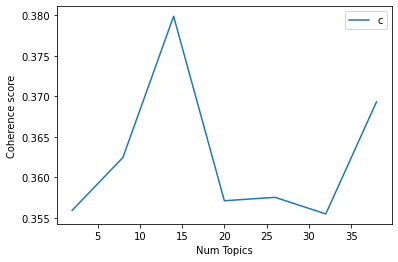

In [19]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3559
Num Topics = 8  has Coherence Value of 0.3625
Num Topics = 14  has Coherence Value of 0.3799
Num Topics = 20  has Coherence Value of 0.3571
Num Topics = 26  has Coherence Value of 0.3575
Num Topics = 32  has Coherence Value of 0.3555
Num Topics = 38  has Coherence Value of 0.3693


In [21]:
# Build LDA model
lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
## USING TF-IDF
## TOPICS = 30
# minimum_probability=0.0 - total probability = 1
train_vecs = []
for i in range(len(df)):
    top_topics = (
        lda_model_final.get_document_topics(corpus
                                      ,minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(10)]
    #topic_vec.extend([len(df.iloc[i].proj_desc)])
    train_vecs.append(topic_vec)


In [23]:
topic_score = pd.DataFrame(train_vecs)
topic_score.head()

,0,1,2,3,4,5,6,7,8,9
0,"(1, 0.00091324234)","(1, 0.0008990198)","(1, 0.0025479372)","(1, 0.0010255082)","(1, 0.06992756)","(1, 0.0012995835)","(1, 0.0007895756)","(1, 0.0016722439)","(1, 0.001299409)","(1, 0.00067927374)"
1,"(1, 0.00091324246)","(1, 0.00089901994)","(1, 0.002547937)","(1, 0.0010255083)","(1, 0.06992762)","(1, 0.0012995836)","(1, 0.0007895757)","(1, 0.0016722444)","(1, 0.0012994088)","(1, 0.00067927374)"
2,"(1, 0.0009132424)","(1, 0.00089901994)","(1, 0.0025479367)","(1, 0.0010255078)","(1, 0.069927506)","(1, 0.0012995835)","(1, 0.0007895757)","(1, 0.0016722439)","(1, 0.001299409)","(1, 0.0006792738)"
3,"(1, 0.0009132424)","(1, 0.0008990198)","(1, 0.002547937)","(1, 0.0010255078)","(1, 0.069927625)","(1, 0.0012995835)","(1, 0.00078957574)","(1, 0.0016722439)","(1, 0.001299409)","(1, 0.00067927374)"
4,"(1, 0.0009132423)","(1, 0.00089901994)","(1, 0.002547937)","(1, 0.001025508)","(1, 0.069927484)","(1, 0.0012995836)","(1, 0.0007895755)","(1, 0.0016722444)","(1, 0.0012994088)","(1, 0.00067927374)"
